# Neural Style Transfer

## Background

The idea of artistic style transfer is to minimize content loss and style loss between the reconstructed image and the original image.

### Content Loss

Image content can simply be represented by an output of some layer in the network. The deeper layer outputs will represent more high-level feature.
Content loss is defined by mean square error between the features corresponding to layer l of the original image and the reconstructed image.

Given:
- $P$ = feature output of layer $l$ of the original image
- $F$ = feature output of layer $l$ of the reconstucted image

Content loss can be written in the following expression:
- $L_{\text{content}} = \frac{1}{K_l H_l W_l} \sum_{i, j, k} (F^l_{ijk} - P^l_{ijk})^2$ where $K_l$ = number of filters $H_l$ = feature's height $W_l$ = feature's width

### Style Loss

Image style can be represented by an inner product of an output feature of each layer.
A matrix resulted from computing an inner product is called a Gram matrix which can be written in the following expression:
- $G^l_{ij} = \sum_{k} F_{ik}^l F_{jk}^l$ where $k$ = pixel, $i, j$ = filter

Given:
- $A^l$ = style representation of layer $l$ of the style image
- $G^l$ = style representation of layer $l$ of the reconstructed image

Style loss can be written in the following expression:
- $L_{\text{style}}^l = \frac{1}{K_l W_l H_l} \frac{1}{K_l^2} \sum_{i, j} (G^l_{ij} - A^l_{ij})^2$ where $K_l$ = number of filters $H_l$ = feature's height $W_l$ = feature's width

The mean square error is scale by the number of pixels presented in the output feature.

The total style loss will be a weighted sum of all style representations. Typically, the weight should decrease as it goes deeper into the network since we want to prioritize low-level features to imitate the actual styles more closedly.

$L_{\text{style}} = \sum_l w_l L_{\text{style}}^l$

The total loss will be a weighted sum between the content loss and the style loss

$L_{\text{total}} = \alpha L_{\text{content}} + \beta L_{\text{style}}$

However, to construct a smoother image, we will also introduce a total variation loss which is sum squared differences between a pixel and its neighboring pixels.

$L_{\text{tv}} = \sum_{i, j, k} (T_{i, j+1, k} - T_{i, j, k})^2 + (T_{i+1, j, k} - T_{i, j, k})^2$ where T is the reconstructed image

Now, the formula for total loss is

$L_{\text{total}} = \alpha L_{\text{content}} + \beta L_{\text{style}} + \gamma L_{\text{tv}}$

## Methodology

- Style representations are computed from feature outputs of the first layer and all the max-pool activations in the network (conv1_2 and activated outputs of conv1_2, conv2_2, conv3_4, conv4_4, conv5_4).

- Content is defined by an activated output of conv3_4

- The reconstructed image is either initialized as random noise or a copy of the original image.

- The reconstructed image and style image are fed into two networks. The loss is computed with the formula mentioned above and backpropagated through the reconstructed image (each parameter is a pixel value itself).


In [209]:
# import resources
%matplotlib inline

import torch
from torch import nn
import torch.optim as optim
from torchvision import transforms as T, models

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODELS = {
    'vgg19': {'model_init': models.vgg19, 'rep_layers':[0, 4, 9, 18, 20, 27]},
    'efficientnet_b0': {'model_init': models.efficientnet_b0, 'rep_layers':[0, 3, 5, 8, 15, 16]}
}

In [221]:
model_name = 'vgg19'
model = MODELS[model_name]['model_init'](pretrained=True).to(device)
layers = MODELS[model_name]['rep_layers']

for param in model.parameters():
    param.requires_grad_(False)

/homes/iws/lpremc/miniconda3/envs/cse490g1/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/homes/iws/lpremc/miniconda3/envs/cse490g1/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [230]:
def load_image(img_path, size=600):
    img = Image.open(img_path).convert('RGB')
    img = T.Compose([T.Resize(size), T.ToTensor()])(img).unsqueeze(0)
    return img

def to_numpy(x):
    x = x.to("cpu").clone().detach()
    x = x.numpy().squeeze()
    x = x.transpose(1, 2, 0)
    x = x.clip(0, 1)
    return x

def get_features(x):
    features = []
    modules = list(model.features._modules.values())
    if model_name == 'efficientnet_b0':
        modules = []
        for module in list(model.features._modules.values()):
            modules.extend(list(module._modules.values()))
    for layer in modules:
        x = layer(x)
        features.append(x)
    return [features[i] for i in layers]

In [231]:
content = load_image('imgs/style1.jpg').to(device)
for x in get_features(content):
    print(x.shape)

torch.Size([1, 64, 600, 809])
torch.Size([1, 64, 300, 404])
torch.Size([1, 128, 150, 202])
torch.Size([1, 256, 75, 101])
torch.Size([1, 512, 75, 101])
torch.Size([1, 512, 37, 50])


In [232]:
style_layer_weights = [1, 0.8, 0.5, 0.3, 0.1, 0]

def compute_gram(x):
    _, d, w, h = x.shape
    x = x.view(d, h*w)
    return torch.mm(x, x.t())
    
def content_loss(content_features, target_features):
  return (target_features[-3] - content_features[-3]).pow(2).mean()

def style_loss(style_features, target_features):
  loss = 0
  for i in range(len(target_features)):
    target_feature = target_features[i]
    _, d, h, w = target_feature.shape
    
    target_gram = compute_gram(target_features[i])
    style_gram = compute_gram(style_features[i])

    loss += style_layer_weights[i] * (target_gram - style_gram).pow(2).mean()  / (d * h * w)
  return loss

def total_variation_loss(x):      
      tv_h = (x[:,:,1:,:] - x[:,:,:-1,:]).pow(2).sum()
      tv_w = (x[:,:,:,1:] - x[:,:,:,:-1]).pow(2).sum()    
      return tv_h + tv_w

In [233]:
def style_transfer(content, style, epoch, lr=0.03, style_weight=0.1, tv_weight=1e-3, random_noise=False, show_every=1000):
  losses = []
  targets = []
  # initialize random noise
  target = content.clone().to(device).requires_grad_(True)
  if random_noise:
    target = torch.rand(content.shape).to(device).requires_grad_(True)
  targets.append(target.clone())
  optimizer = optim.Adam([target], lr)
  t = tqdm(range(0, epoch))
  grayscale = T.Grayscale(3)
  content_features = get_features(content)
  style_features = get_features(style)
  for it in t:
      c_loss = content_loss(content_features, get_features(target))
      s_loss = style_weight * style_loss(style_features, get_features(target))
      tv_loss = tv_weight * total_variation_loss(target)
      loss = c_loss + s_loss + tv_loss
      losses.append(loss.item())
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      if (it + 1) % show_every == 0:
        targets.append(target.clone())
  return targets, losses 

In [234]:
def plot_loss(loss, path):
    fig, ax = plt.subplots(1, figsize=(6, 4))
    ax.plot(loss)
    ax.set_xlabel('iters')
    ax.set_ylabel('loss')
    ax.set_yscale('log')
    fig.savefig(path)

In [235]:
ITERS = 2000
SHOW_EVERY = 500
H = 2.5
W = 3.5

## Results and Experiments

##### **Content Image**
<img src="imgs/pic6.jpg" height=200><br>
<sub><sup>retrieved from nbcnews.com</sup></sub>
### Tuning style weight
<img src="results/beta_range.png">

### Tuning total variantion loss weight
<img src="results/tv_range.png">

### Initializing with random noise vs a copy of the content image

##### **Style Image 1**
<img src="imgs/style3.jpg" height=200><br>
<sub><sup>retrieved from fineartamerica.com</sup></sub>

##### **Result**
<img src="results/prog_style1.png">

##### **Style Image 2**
<img src="imgs/style5.jpg" height=200><br>
<sub><sup>The Starry Night retrieved from sanctuarymentalhealth.org</sup></sub>

##### **Result**
<img src="results/prog_style2.png">

##### **My own artwork style**
<img src="imgs/pic4.jpg" height=300>

##### **Result**
<img src="results/prog_my_art.png">

##### **Loss**
<img src="results/loss.png">


### Tuning style weight

In [236]:
content = load_image(f'imgs/pic6.jpg', size=200).to(device)
style = load_image(f'imgs/style3.jpg', size=200).to(device)

100%|██████████| 2000/2000 [00:43<00:00, 45.99it/s]


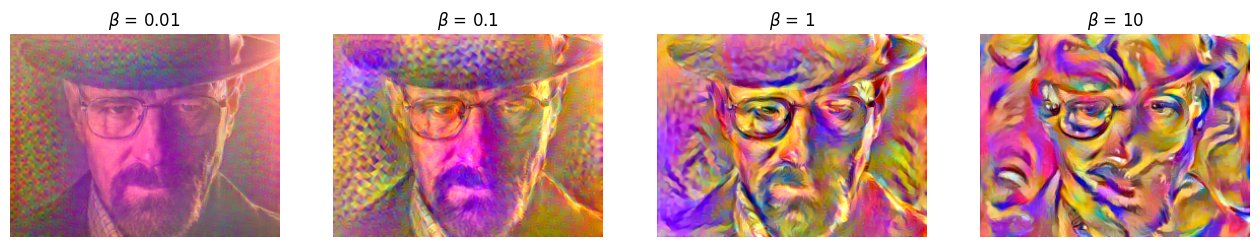

In [118]:
targets = []
style_weights = [1e-2, 1e-1, 1, 10]
for style_weight in style_weights:
    targets_, loss = style_transfer(content, style, ITERS, lr=0.03, style_weight=style_weight, tv_weight=1e-3, show_every=SHOW_EVERY, random_noise=True)
    targets.append(targets_[-1])
fig, ax = plt.subplots(1, len(targets), figsize=(len(targets) * W, H))
for i, target in enumerate(targets):
    ax[i].imshow(to_numpy(target))
    ax[i].set_title(r'$\beta$ = {}'.format(style_weights[i]))
    ax[i].axis('off')
fig.savefig('results/beta_range.png')

### Tuning total variantion loss weight

100%|██████████| 2000/2000 [00:43<00:00, 46.16it/s]


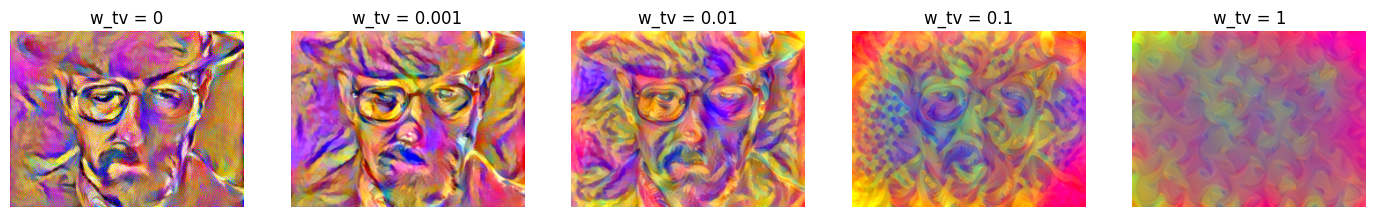

In [135]:
targets = []
tv_weights = [0, 1e-3, 1e-2, 0.1, 1]
for tv_weight in tv_weights:
    targets_, loss = style_transfer(content, style, ITERS, lr=0.03, style_weight=2, tv_weight=tv_weight, show_every=SHOW_EVERY, random_noise=True)
    targets.append(targets_[-1])
fig, ax = plt.subplots(1, len(targets), figsize=(len(targets) * W, H))
for i, target in enumerate(targets):
    ax[i].imshow(to_numpy(target))
    ax[i].set_title(r'w_tv = {}'.format(tv_weights[i]))
    ax[i].axis('off')
fig.savefig('results/tv_range.png')

### Style transfer starting with random noise vs. an original image copy

#### Style 1

100%|██████████| 2000/2000 [00:42<00:00, 47.45it/s]


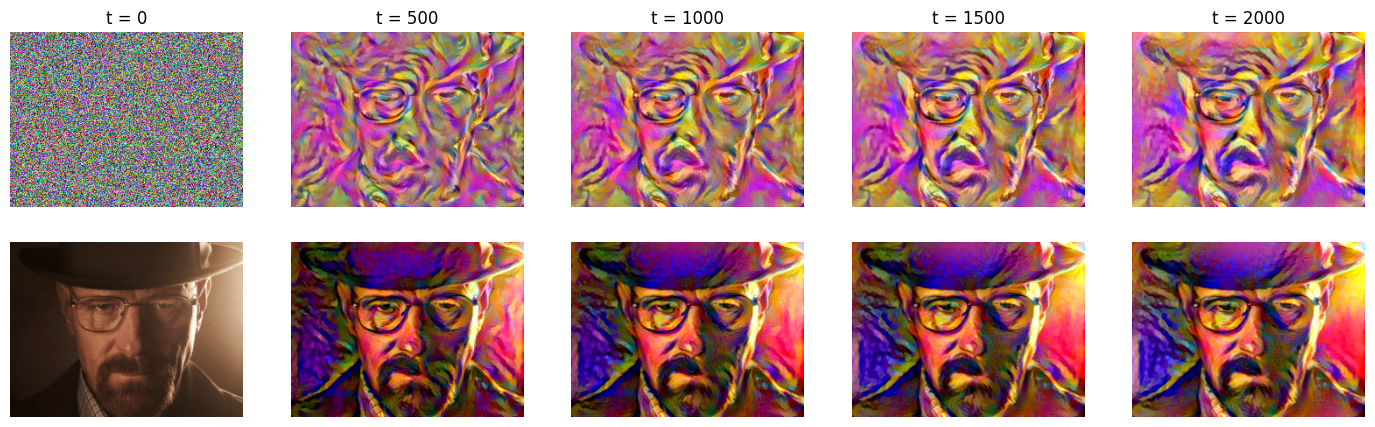

In [237]:
targets1, loss1 = style_transfer(content, style, ITERS, lr=0.03, style_weight=2, tv_weight=1e-3, show_every=SHOW_EVERY, random_noise=True)
targets2, loss2 = style_transfer(content, style, ITERS, lr=0.03, style_weight=2, tv_weight=1e-3, show_every=SHOW_EVERY, random_noise=False)
fig, ax = plt.subplots(2, len(targets1), figsize=(len(targets1) * W, 2 * H))
for i, target in enumerate(targets1):
    ax[0][i].set_title(r't = {}'.format(i * SHOW_EVERY))
    ax[0][i].imshow(to_numpy(target))
    ax[0][i].axis('off')
for i, target in enumerate(targets2):
    ax[1][i].imshow(to_numpy(target))
    ax[1][i].axis('off')
fig.savefig('results/prog_style1.png')

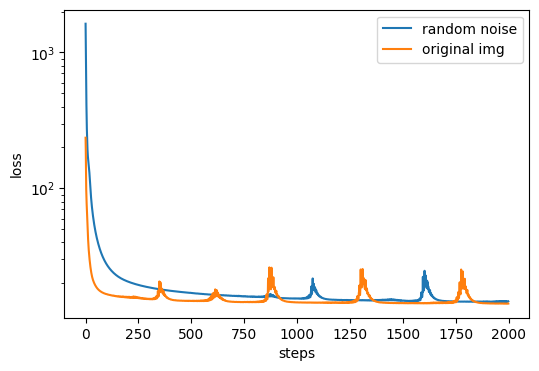

In [159]:
fig, ax = plt.subplots(1, figsize=(6, 4))
ax.plot(loss1, label='random noise')
ax.plot(loss2, label='original img')
ax.set_xlabel('steps')
ax.set_ylabel('loss')
ax.set_yscale('log')
ax.legend()
fig.savefig('results/loss.png')

#### Style 2

In [151]:
style2 = load_image(f'imgs/style5.jpg', size=200).to(device)

100%|██████████| 2000/2000 [00:42<00:00, 46.68it/s]


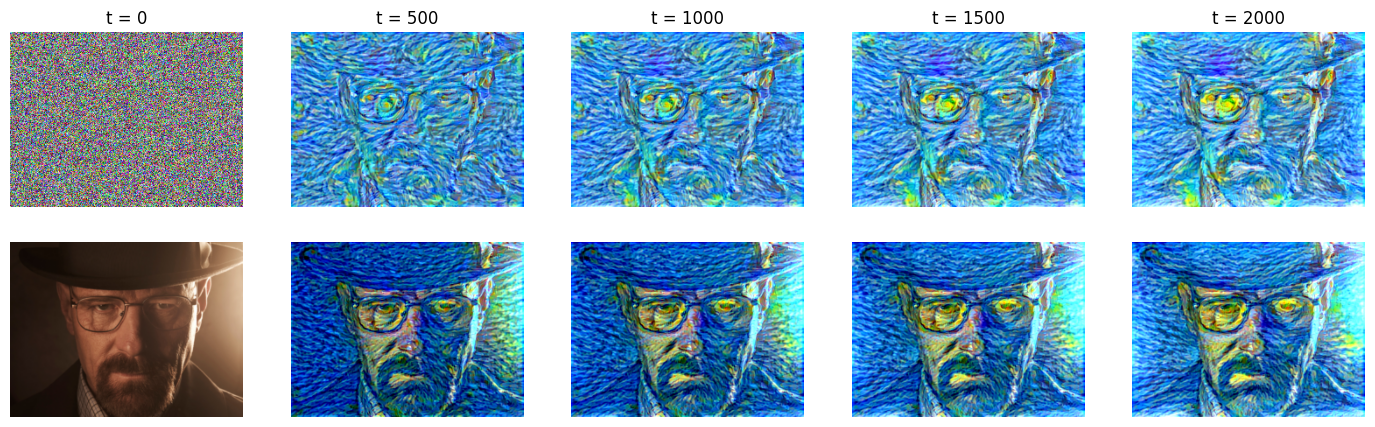

In [152]:
targets1, loss1 = style_transfer(content, style2, ITERS, lr=0.03, style_weight=2, tv_weight=1e-3, show_every=SHOW_EVERY, random_noise=True)
targets2, loss2 = style_transfer(content, style2, ITERS, lr=0.03, style_weight=2, tv_weight=1e-3, show_every=SHOW_EVERY, random_noise=False)
fig, ax = plt.subplots(2, len(targets1), figsize=(len(targets1) * W, 2 * H))
for i, target in enumerate(targets1):
    ax[0][i].set_title(r't = {}'.format(i * SHOW_EVERY))
    ax[0][i].imshow(to_numpy(target))
    ax[0][i].axis('off')
for i, target in enumerate(targets2):
    ax[1][i].imshow(to_numpy(target))
    ax[1][i].axis('off')
fig.savefig('results/prog_style2.png')

#### Style from my own artwork

In [153]:
my_art = load_image(f'imgs/pic4.jpg', size=200).to(device)

100%|██████████| 2000/2000 [00:43<00:00, 45.75it/s]


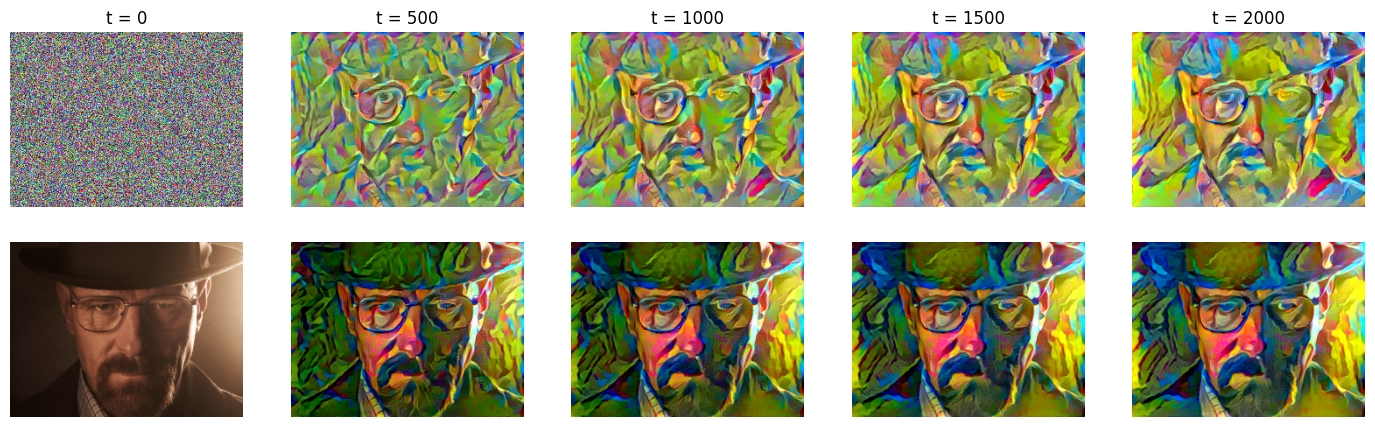

In [154]:
targets1, loss1 = style_transfer(content, my_art, ITERS, lr=0.03, style_weight=2, tv_weight=1e-3, show_every=SHOW_EVERY, random_noise=True)
targets2, loss2 = style_transfer(content, my_art, ITERS, lr=0.03, style_weight=2, tv_weight=1e-3, show_every=SHOW_EVERY, random_noise=False)
fig, ax = plt.subplots(2, len(targets1), figsize=(len(targets1) * W, 2 * H))
for i, target in enumerate(targets1):
    ax[0][i].set_title(r't = {}'.format(i * SHOW_EVERY))
    ax[0][i].imshow(to_numpy(target))
    ax[0][i].axis('off')
for i, target in enumerate(targets2):
    ax[1][i].imshow(to_numpy(target))
    ax[1][i].axis('off')
fig.savefig('results/prog_my_art.png')